In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import numpy as np
import random

In [2]:
n_timesteps_in = 50 
n_timesteps_out = 60
n_features_in = 1
n_features_out = 1

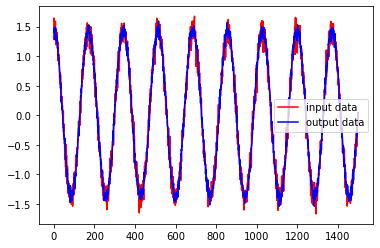

In [3]:
time_series_length = 1500
t = np.linspace(0, 5, time_series_length)
ts_input = np.cos(t) / 11 + 8 * np.cos(t*11) + 0.7 * np.random.standard_normal(size=time_series_length)
ts_output = np.cos(t) / 9 + 12 * np.cos(t*11) + 0.5 * np.random.standard_normal(size=time_series_length)

ts_norm_input = (ts_input - np.mean(ts_input)) / np.std(ts_input)
ts_norm_output = (ts_output - np.mean(ts_output)) / np.std(ts_output)
plt.plot(ts_norm_input, 'r', label = 'input data')
plt.plot(ts_norm_output,'b', label = 'output data')

plt.legend()

In [4]:
train_size = int(len(ts_input) * 0.75)
test_size = len(ts_input) - train_size

train_input, test_input = ts_norm_input[0:train_size], ts_norm_input[train_size:len(ts_input)]
train_output, test_output = ts_norm_output[0:train_size], ts_norm_output[train_size:len(ts_input)]

In [5]:
seq_len = max(n_timesteps_in, n_timesteps_out)
def create_dataset():
    train_input_data, train_output_data = [], []
    for i in range(500):
        rand_ind_train = random.randint(0, len(train_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_train:rand_ind_train+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_train:rand_ind_train+n_timesteps_out]
        train_input_data.append(input_seq)
        train_output_data.append(output_seq)

    test_input_data, test_output_data = [], []   
    for i in range(5):
        rand_ind_test = random.randint(0, len(test_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_test:rand_ind_test+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_test:rand_ind_test+n_timesteps_out]
        test_input_data.append(input_seq)
        test_output_data.append(output_seq)
    return np.array(train_input_data), np.array(train_output_data), np.array(test_input_data), np.array(test_output_data)

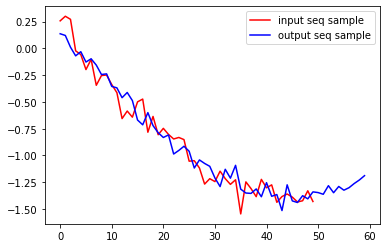

In [6]:
train_input_data, train_output_data, test_input_data, test_output_data = create_dataset()
plt.plot(train_input_data[0], 'r', label = 'input seq sample')
plt.plot(train_output_data[0], 'b', label = 'output seq sample')
plt.legend()

In [7]:
train_input_data = np.reshape(train_input_data, (train_input_data.shape[0], n_timesteps_in, n_features_in))
train_output_data = np.reshape(train_output_data, (train_input_data.shape[0], n_timesteps_out, n_features_out))

test_input_data = np.reshape(test_input_data, (test_input_data.shape[0], n_timesteps_in, n_features_in))
test_output_data = np.reshape(test_output_data, (test_input_data.shape[0], n_timesteps_out, n_features_out))

In [8]:
n_units = 256

encoder_inputs = keras.Input(shape=(n_timesteps_in, n_features_in))
encoder = keras.layers.LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  keras.layers.LSTM(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [9]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        264192      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [10]:
model.compile(optimizer='adam', loss='mse')
decoder_inputs = np.zeros(train_output_data.shape)

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

model.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=100, batch_size=64, validation_split=0.25, callbacks = my_callbacks, verbose=2)

Epoch 1/100
6/6 - 12s - loss: 0.8594 - val_loss: 1.5772 - 12s/epoch - 2s/step
Epoch 2/100
6/6 - 2s - loss: 0.8101 - val_loss: 0.7367 - 2s/epoch - 400ms/step
Epoch 3/100
6/6 - 4s - loss: 0.6842 - val_loss: 0.5522 - 4s/epoch - 667ms/step
Epoch 4/100
6/6 - 4s - loss: 0.4711 - val_loss: 0.2512 - 4s/epoch - 658ms/step
Epoch 5/100
6/6 - 4s - loss: 0.2383 - val_loss: 0.1199 - 4s/epoch - 642ms/step
Epoch 6/100
6/6 - 3s - loss: 0.1443 - val_loss: 0.1204 - 3s/epoch - 558ms/step
Epoch 7/100
6/6 - 4s - loss: 0.0858 - val_loss: 0.0714 - 4s/epoch - 602ms/step
Epoch 8/100
6/6 - 3s - loss: 0.0463 - val_loss: 0.0318 - 3s/epoch - 518ms/step
Epoch 9/100
6/6 - 3s - loss: 0.0262 - val_loss: 0.0196 - 3s/epoch - 549ms/step
Epoch 10/100
6/6 - 3s - loss: 0.0205 - val_loss: 0.0174 - 3s/epoch - 532ms/step
Epoch 11/100
6/6 - 3s - loss: 0.0147 - val_loss: 0.0112 - 3s/epoch - 531ms/step
Epoch 12/100
6/6 - 4s - loss: 0.0093 - val_loss: 0.0076 - 4s/epoch - 591ms/step
Epoch 13/100
6/6 - 3s - loss: 0.0077 - val_loss: 0

In [11]:
decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model.predict([test_input_data, decoder_inputs])

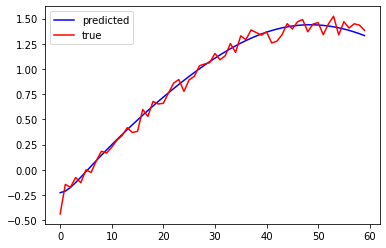

In [12]:
plt.plot(y_pred[0], 'b', label = 'predicted')
plt.plot(test_output_data[0], 'r', label = 'true')

plt.legend()